In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

### 3.0：原始融合机制 ＋ CNN多尺度

# Data
修改channel 加入ht 长方形patch计算

In [2]:
import numpy as np
import os, sys
import random #shuffle
from netCDF4 import Dataset
def CMIPdata(Xdata, Ydata, out , myform):
    inp1 = Dataset(Xdata,'r')
    inp2 = Dataset(Ydata,'r')
    sst_1 = np.zeros((myform,140,12,24,72))
    t300_1 = np.zeros((myform,140,12,24,72))

    #首年序列
    #i= 21个模式
    for i in range(myform):
        sst_1[i,:,:,:,:] = inp1.variables['sst1'][1+141*i:141+141*i,0:12,:,:]
        t300_1[i,:,:,:,:] = inp1.variables['t300'][1+141*i:141+141*i,0:12,:,:]
    #(21,140,12,24,72)
    #首年序列

    
    #flatted扁平化                                             
    sst_2 = np.zeros((myform,1680,24,72))
    t300_2 = np.zeros((myform,1680,24,72))
    for i in range(myform):
        for j in range(140):
            sst_2[i,j*12:(j+1)*12,:,:] = sst_1[i,j,:,:,:]
            t300_2[i,j*12:(j+1)*12,:,:] = t300_1[i,j,:,:,:]
    
        #(21,1680,24,72)
        #每个模式 139*12+1 = 1680 个序列 序列长度为12

    #丢弃1个月 1862.1
    sst_2 = sst_2[:,1:,:,:]
    t300_2 = t300_2[:,1:,:,:]
    #(form,1679,24,72)


    winsize = 12
    #winnum = 1679-winsize +1 #1668
    """跳跃六个月滑窗 = 6"""
    ts=6 
    #(1679-12)/6+1 =27
    winnum=int((1679-12)/ts +1) 
    
    sst_3 = np.zeros((myform,winnum, 12, 24, 72))
    t300_3 = np.zeros((myform, winnum, 12, 24, 72))
    for i in range(myform):
        for j in range(winnum):
            #print(j)
            sst_3[i,j,:,:,:] = sst_2[i,(j*ts):(j*ts)+winsize,:,:]
            t300_3[i,j,:,:,:] = t300_2[i,(j*ts):(j*ts)+winsize,:,:]
            

    sst_4 = np.zeros((int(winnum*myform),12,24,72))
    t300_4 = np.zeros((int(winnum*myform),12,24,72))
    for i in range(myform):
        sst_4[i*winnum:(i+1)*winnum,:,:,:] = sst_3[i,:,:,:,:]
        t300_4[i*winnum:(i+1)*winnum,:,:,:] = t300_3[i,:,:,:,:]


    trX = np.zeros((int(winnum*myform),12, 2, 24, 72))
    trX[:,:,0,:,:] = sst_4
    trX[:,:,1,:,:] = t300_4
    del sst_1,sst_2,sst_3,sst_4
    del t300_1,t300_2,t300_3,t300_4

    #保存np数组
    #(5859, 12, 2, 24, 72 )
    #np.save("./CMIPdata/CMIP_trX_21_ts6_out.npy",trX) 

    #label
    #平铺
    pr_1 = np.zeros(((myform),1692))#21,1692
    for i in range(myform):
        for j in range(141):
            pr_1[i,j*12:(j+1)*12] = inp2.variables['pr'][(141*i)+j,:,0,0]
            
    #out
    pr_2 =  np.zeros((myform,winnum,out))#form,1668,1
    for i in range(myform):
        for j in range(winnum):
            pr_2[i,j,:] = pr_1[i,(j*ts):(j*ts)+out]

    trY = np.zeros((int(winnum*myform),out))#form*1668,1
    for i in range(myform):
        trY[i*winnum:(i+1)*winnum,:] = pr_2[i,:,:]

    #np.save("./CMIPdata/CMIP_trY_21_ts6_out%s.npy"%out,trY)
    trY_decoder_input = np.zeros((int(winnum*myform),out))
    trY_decoder_input[:,1:] = trY[:,:-1]

    #return trX[1:,:,:] ,trY.reshape(-1,24,1)[1:,:,:] ,trY_decoder_input
    return trX ,trY.reshape(-1,24,1) ,trY_decoder_input.reshape(-1,24,1)

def GOSDAdata(Xdata, Ydata, out):
    #test data
    inp11 = Dataset(Xdata,'r')
    inp22 = Dataset(Ydata,'r')
                                              
    sst_11 = np.zeros((33,12,24,72)) #1983-2015
    t300_11 = np.zeros((33,12,24,72))

    sst_11[:,:,:,:] = inp11.variables['sst'][3:,0:12,:,:]
    t300_11[:,:,:,:] = inp11.variables['t300'][3:,0:12,:,:]
    #(33,12,24,72)

    sst_22 = np.zeros((396,24,72))
    t300_22 = np.zeros((396,24,72))

    for i in range(33):
        sst_22[i*12:(i+1)*12,:,:] = sst_11[i,:,:,:]
        t300_22[i*12:(i+1)*12,:,:] = t300_11[i,:,:,:]
    #(396,24,72)
    #丢弃一个月，便于制作滑窗序列
    sst_22 = sst_22[1:,:,:]
    t300_22 = t300_22[1:,:,:]#(395,24,72)

    #滑窗
    winsize = 12
    winnum = 395-winsize + 1 #384
    sst_33 = np.zeros((winnum, winsize, 24, 72))#(384, 12, 24, 72)
    t300_33 = np.zeros((winnum, winsize, 24, 72))

    for i in range(winnum):
        sst_33[i,:,:,:] = sst_22[i:i+12,:,:]
        t300_33[i,:,:,:] = t300_22[i:i+12,:,:]
    #(384,12,24,72)


    #channel = 2
    #testX = np.zeros((winnum,12,24,72,2))#384
    #testX[:,:,:,:,0] = sst_33
    #testX[:,:,:,:,1] = t300_33
    #sst_33 = sst_33.swapaxes(1, 3)

    testX = np.zeros((winnum, 12, 2, 24, 72))#384
    testX[:,:,0,:,:] = sst_33
    testX[:,:,0,:,:] = t300_33
    del sst_11,sst_22,sst_33
    del t300_11,t300_22,t300_33
    #testX = testX.reshape(384,12,3456)

    #label
    inpv22 = np.zeros((408))#2017-1984 +1=34
    for i in range(34):
        inpv22[i*12:(i+1)*12] = inp22.variables['pr'][i+2,:,0,0]# +2:从1984开始
        #(408)

    testY = np.zeros((winnum,out,1))
    #out = 1
    #滑窗
    for i in range(winnum):
        testY[i,:,0] = inpv22[i:i+out]#24
    #(384,out,1)

    return testX, testY

def SODAdata(Xdata, Ydata, out):
    inp1 = Dataset(Xdata,'r')
    inp2 = Dataset(Ydata,'r')

    #time_step = 1 month                                               
    sst_1 = np.zeros((99,12,24,72))
    t300_1 = np.zeros((99,12,24,72))

    sst_1[:,:,:,:] = inp1.variables['sst'][1:,0:12,:,:]
    t300_1[:,:,:,:] = inp1.variables['t300'][1:,0:12,:,:]
    #(99,12,24,72)
    #1872-1970

    sst_2 = np.zeros((1188,24,72))
    t300_2 = np.zeros((1188,24,72))

    for i in range(99):
        sst_2[i*12:(i+1)*12,:,:] = sst_1[i,:,:,:]
        t300_2[i*12:(i+1)*12,:,:] = t300_1[i,:,:,:]
    #(1188,24,72)
    #丢弃一个月，便于制作滑窗序列
    sst_2 = sst_2[1:,:,:]
    t300_2 = t300_2[1:,:,:]#(1187,24,72)

    sst_3 = np.zeros((1176,12,24,72))
    t300_3 = np.zeros((1176,12,24,72))
    #滑窗
    for i in range(1176):
        sst_3[i:,:,:] = sst_2[i:i+12,:,:]
        t300_3[i,:,:,:] = t300_2[i:i+12,:,:]
    #(1176,12,24,72)

    #channel = 2
    #trX = np.zeros((1176,12,24,72,2))
    #trX[:,:,:,:,0] = sst_3
    #trX[:,:,:,:,1] = t300_3
    trX = np.zeros((1176,12,2,24,72))
    trX[:,:,0,:,:] = sst_3
    trX[:,:,1,:,:] = t300_3
    del sst_1,sst_2,sst_3
    del t300_1,t300_2,t300_3

    #保存np数组
    #np.save("./SODAdata/SODA_trX_ts1_out.npy",trX)

    #label
    inpv2 = np.zeros((1200))
    for i in range(100):
        inpv2[i*12:(i+1)*12] = inp2.variables['pr'][i,:,0,0]
    #(1200)

    #out = 1
    trY = np.zeros((1176,out,1))
    #滑窗
    for i in range(1176):
        trY[i,:,0] = inpv2[i:i+out]#24
    #(1176,24)
    
    
    trY_decoder_input = np.zeros((1176,out,1))
    trY_decoder_input[:,1:,:] = trY[:,:-1,:]

    #np.save("./SODAdata/SODA_trY_ts1_out%s.npy"%out,trY) 
    return trX , trY, trY_decoder_input

trX, trY, trY_decoder_input = CMIPdata('/home/d/Q/liyanqiu/saconvlstm/CMIP5.input.36mon.1861_2001.nc',\
                                          '/home/d/Q/liyanqiu/saconvlstm/CMIP5.label.12mon.1863_2003.nc', 24,  21)

testX, testY = GOSDAdata('/home/d/Q/liyanqiu/saconvlstm/GODAS.input.36mon.1980_2015.nc',\
                         '/home/d/Q/liyanqiu/saconvlstm/GODAS.label.12mon.1982_2017.nc', 24)

trX_SODA, trY_SODA ,trY_decoder_input_SODA = SODAdata('/home/d/Q/liyanqiu/saconvlstm/SODA.input.36mon.1871_1970.nc',
                              '/home/d/Q/liyanqiu/saconvlstm/SODA.label.12mon.1873_1972.nc',24)


# 在放入dataload 前还需要shuffle
# shuffle
print(trX.shape[0])
indices = np.arange(trX.shape[0])
np.random.shuffle(indices)
trX = trX[indices]
trY = trY[indices]
trY_decoder_input = trY_decoder_input[indices]



indices_soda = np.arange(trX_SODA.shape[0])
np.random.shuffle(indices_soda)
trX_SODA = trX_SODA[indices_soda]
trY_SODA = trY_SODA[indices_soda]
trY_decoder_input_SODA = trY_decoder_input_SODA[indices_soda]



class MyDataSet(Data.Dataset):
    """自定义DataLoader"""
    def __init__(self, enc_inputs,  dec_outputs):
        super(MyDataSet, self).__init__()
        self.enc_inputs = enc_inputs
        #self.dec_inputs = dec_inputs
        self.dec_outputs = dec_outputs

    def __len__(self):
        return self.enc_inputs.shape[0]

    def __getitem__(self, idx):
        return self.enc_inputs[idx],  self.dec_outputs[idx]

batch_size = 64
""" 
trainsize = 2000 #选择cmip训练数量
trX = trX[:trainsize]
trY = trY[:trainsize]


加入测试数据进行训练
trX = np.concatenate((trX,testX[:100]),axis=0)
trY = np.concatenate((trY,testY[:100]))
"""

#train split
split_index = int(trX.shape[0]*0.8)
split_index_soda = int(trX_SODA.shape[0]*0.8)

print("split_index_soda:" + str(split_index_soda))
print("split_index:" + str(split_index))

target_month = 5

loader_train = Data.DataLoader(
    MyDataSet(
        trX[:split_index].astype(np.float32), #(1176, 12, 2, 24, 72)
        trY[:split_index, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle = True)
loader_valid = Data.DataLoader(
    MyDataSet(
        trX[split_index:].astype(np.float32), 
        trY[split_index:, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle=False)

loader_train_sado = Data.DataLoader(
    MyDataSet(
        trX_SODA[:split_index_soda].astype(np.float32), 
        trY_SODA[:split_index_soda, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle = True)
loader_valid_soda = Data.DataLoader(
    MyDataSet(
        trX_SODA[split_index_soda:].astype(np.float32), 
        trY_SODA[split_index_soda:, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle=False)
"""
loader_train = Data.DataLoader(
    MyDataSet(
        trX.astype(np.float32), #(1176, 12, 2, 24, 72)
        trY[:, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle = True)
"""
loader_sado = Data.DataLoader(
    MyDataSet(
        trX_SODA[:500].astype(np.float32), 
        trY_SODA[:500, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle = True)

#testdataloader

loader_test = Data.DataLoader(
    MyDataSet(
        testX[:].astype(np.float32), 
        testY[:, target_month-1:target_month].astype(np.float32).reshape((-1,1))), 
    batch_size, shuffle = False)

testY = testY[:, target_month-1:target_month].astype(np.float32).reshape((-1,1))

print(trX.shape)
print(trX_SODA.shape)
print(testX.shape)
print(testY.shape)
print(len(testX))
print(trX_SODA.shape)
print("----------------------------Train Data----------------------------")
#print(trX[:split_index,].astype(np.float32).shape)
#print(trY[:split_index, target_month-1:target_month].reshape((-1,1)).shape)

5838
split_index_soda:940
split_index:4670
(5838, 12, 2, 24, 72)
(1176, 12, 2, 24, 72)
(384, 12, 2, 24, 72)
(384, 1)
384
(1176, 12, 2, 24, 72)
----------------------------Train Data----------------------------


# Model

In [3]:
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)
    
#feed forward
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1) # 在给定的维度上将张量进行分块。沿着-1分成两块
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)#geglu大小除以2
        )

    def forward(self, x):
        return self.net(x)
    
#attention
def attn(q, k, v):
    sim = einsum('b i d, b j d -> b i j', q, k)
    attn = sim.softmax(dim = -1)
    out = einsum('b i j, b j d -> b i d', attn, v)
    return out

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        dropout = 0.
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, einops_from, einops_to, **einops_dims):
        h = self.heads
        #print(x.shape)[16, 28, 64]
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)#参数在to_qkv里边
        #print(q.shape)[16, 28, 256]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))#qkv头参数
        q *= self.scale

        # splice out classification token at index 1
        # 在索引1处拼接出分类标记
        (cls_q, q_), (cls_k, k_), (cls_v, v_) = map(lambda t: (t[:, 0:1], t[:, 1:]), (q, k, v))
        #[64, 1, 64]
        #[64, 27, 64]


        # let classification token attend to key / values of all patches across time and space
        # 让cla token关注跨时间和空间的所有patch的键/值
        cls_out = attn(cls_q, k, v)# ！！！对q的处理
        #[64, 1, 64]

        # rearrange across time or space
        # 将空间/时间维度移动到批处理维度以处理时间/空间注意力
        q_, k_, v_ = map(lambda t: rearrange(t, f'{einops_from} -> {einops_to}', **einops_dims), (q_, k_, v_))

        # expand cls token keys and values across time or space and concat
        # 跨越时间或空间扩展clstoken的键和值，并将其连接起来。
        r = q_.shape[0] // cls_k.shape[0]# 控制时间或者空间 n or f
        cls_k, cls_v = map(lambda t: repeat(t, 'b () d -> (b r) () d', r = r), (cls_k, cls_v))

        k_ = torch.cat((cls_k, k_), dim = 1)
        v_ = torch.cat((cls_v, v_), dim = 1)
        #[576, 3+1, 64] [192, 9+1, 64]


        # attention
        #q_ [576, 3, 64] 没有class token
        out = attn(q_, k_, v_)
        # out [576, 3, 64] /[192, 9, 64]

        # merge back time or space 合并时间或空间
        out = rearrange(out, f'{einops_to} -> {einops_from}', **einops_dims)#恢复
        # [64, 27, 64] 没有class token

        # concat back the cls token 连接回来的cls token
        out = torch.cat((cls_out, out), dim = 1)#[16, , d]
        #[64, 28, 64]

        # merge back the heads 合并后的头
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)# [16, 109, inner_dim] inner_dim = dim_head * heads所有头的平铺
        #  [16, 28, 256]

        # combine heads out 合并head输出
        return self.to_out(out) # batch * dim
    
    
# main classes
class TimeSformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_classes,
        image_size = 72,
        patch_size = 12,
        channels = 30,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        """注意CNN之后channels会变化"""
        super().__init__()
        #符合则往下运行
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_size // patch_size) ** 2 #平方个数 //向下取整
        num_positions = num_frames * num_patches # 12*num_patches
        patch_dim = channels * patch_size * (patch_size//3)# patch大小

        self.patch_size = patch_size
        self.to_patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_emb = nn.Embedding(num_positions + 1, dim)# 总共出现num_positions + 1个词,多了一个cls_token patch 用多少维来表示一个符号
        self.cls_token = nn.Parameter(torch.randn(1, dim))# [1, dim] 一个可学习的参数

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Time attention
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Spatial attention
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout)) # Feed Forward
            ]))
            #append到layers中
            
        """多尺度CNN"""
        self.projs = nn.ModuleList()
        kernel_size = [5, 9, 17]
        #kernel_size = [17, 9, 5]
        out_chans = 30
        for ks in kernel_size:
            stride = 1
            padding = (ks - stride) // 2
            self.projs.append(nn.Conv2d(2, out_chans, kernel_size=ks, stride=stride, padding=padding))

        """
        self.to_out = nn.Sequential(
            nn.LayerNorm(dim),
            #nn.BatchNorm1d(dim),#修改bn层
            nn.Linear(dim, num_classes)
        )
        """
        
        self.to_out = nn.Linear(dim, num_classes)
        
        

    def forward(self, video):
        # (batch x frames x channels x height x width)
        b, f, _, h, w, *_, device, p = *video.shape, video.device, self.patch_size
        video = rearrange(video, 'b f c h w -> (b f) c h w')
        """
        xs = []
        for i in range(len(self.projs)):
            tx = self.projs[i](video)
            tx = rearrange(tx, '(b1 f1) c h w -> b1 f1 c h w', b1 = b, f1 = f)
            xs.append(tx)
        msvideo = torch.cat(xs, dim=2) #按channel维度拼接
        """
        for i in range(len(self.projs)):
            msvideo = self.projs[i](video)
        
        msvideo = rearrange(msvideo, '(b1 f1) c h w -> b1 f1 c h w', b1 = b, f1 = f)
        
        
        #print(msvideo.shape)torch.Size([16, 12, 30, 24, 72])
        h, w= msvideo.shape[3], msvideo.shape[4]
        assert h % (p//3) == 0 and w % p == 0, f'height {h} and width {w} of video must be divisible by the patch size {p}'
        #print(h) 24
        #print(w) 72

        n = (h // (p//3)) * (w // p)# patch个数 3*3个patch p = 24
        #print(n)
        # 将w*h*c图片切分为N个p1*p2*c的图像块，序列长度变成f*h*w/(p*p/3)
        msvideo = rearrange(msvideo, 'b f c (h p1) (w p2) -> b (f h w) (p1 p2 c)', p1 = p//3, p2 = p)
        #print("patch finish")
        #print(video.shape) [16, 27, 384]
        # torch.Size([16, 108, 384]) 9*12 = 108
        
        #数据处理完毕
        tokens = self.to_patch_embedding(msvideo)# 对每个patch进行嵌入 位置编码

        cls_token = repeat(self.cls_token, 'n d -> b n d', b = b)# [batch_size, 1, dim]
        x =  torch.cat((cls_token, tokens), dim = 1)#按照frames维度进行拼接 [batch_size, (f h w)+1, dim] 对每一个样本增加了一个cls_token
        x += self.pos_emb(torch.arange(x.shape[1], device = device)) #位置编码
        #print(x.shape)[16, 28, 64]

        for (time_attn, spatial_attn, ff) in self.layers:#layers 循环 [ [1, 2, 3], [1, 2, 3], [1, 2, 3] ] d二维list
            x = time_attn(x, 'b (f n) d', '(b n) f d', n = n) + x
            x = spatial_attn(x, 'b (f n) d', '(b f) n d', f = f) + x
            x = ff(x) + x
            
        # print(x.shape) [16, 109, 64]

        cls_token = x[:, 0] #把patch做一个融合 取cls_token！
        #print(cls_token.shape)
        
        return self.to_out(cls_token)
    
    
#Parameters
device = 'cuda'
DIM = 64
IMAGE_SIZE = 72
PATCH_SIZE = 24 #24 18 12 9 6
NUM_CLASSES = 1
NUM_FRAMES = 12
DEPTH = 1 # block个数
HEADS = 4
DIM_HEAD = 64
ATTN_DROPOUT = 0.
FF_DROPOUT = 0.

# (batch x frames x channels x height x width)
model = TimeSformer(dim = DIM, image_size = IMAGE_SIZE, patch_size = PATCH_SIZE, num_frames = NUM_FRAMES, \
        num_classes = NUM_CLASSES, depth = DEPTH, heads = HEADS, dim_head = DIM_HEAD, attn_dropout = ATTN_DROPOUT, \
            ff_dropout = FF_DROPOUT).to(device)
#criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma= 1)
print("if on cuda:",next(model.parameters()).is_cuda)

if on cuda: True


# Train

In [4]:
import pandas as pd 
import datetime
import copy
dfhistory = pd.DataFrame(columns = ["epoch","loss","val_loss"]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)
bestloss = float("inf")
bestcor = 0.
epoch = 20

#polt
train_losses = []

val_losses = []
val_cores = []

for epoch in range(1,epoch+1):
  #train----------------------------------------------------
  model.train()
  loss_sum = 0.0
  step = 1
  for step,(enc_inputs, dec_outputs) in enumerate(loader_train, 1):
      optimizer.zero_grad()

      # 正向
      enc_inputs, dec_outputs = enc_inputs.to(device), dec_outputs.to(device)
      y_pred = model(enc_inputs)
      #print(y_pred)torch.Size([64, 1])
      
      loss = criterion(y_pred, dec_outputs) 

      # 反向
      loss.backward()
      optimizer.step()

      # print
      loss_sum += loss.item()
      #if step%40 == 0:
        #print(("[step = %d] loss: %.3f, ") % (step, loss_sum/step))

  train_losses.append(loss_sum/step)
  

  #valid
  model.eval()
  val_loss_sum = 0.0
  val_cor_sum = 0.0
  val_step = 1

  for val_step, (enc_inputs, dec_outputs) in enumerate(loader_sado, 1):
    with torch.no_grad():# 节点不进行求梯度
      enc_inputs, dec_outputs = enc_inputs.to(device), dec_outputs.to(device)
      outputs = model(enc_inputs)
      #val_loss = criterion(outputs.view(-1), dec_outputs.view(-1)) 
      val_loss =criterion(outputs, dec_outputs)
      #print(outputs.shape)([16, 1])
      val_cor = np.corrcoef(outputs[:,0].cpu(),dec_outputs[:,0].cpu())[0,1]

    val_loss_sum += val_loss.item()
    val_cor_sum += val_cor.item()
    
  val_losses.append(val_loss_sum/val_step)
  val_cores.append(val_cor_sum/val_step)


  # log
  info = (epoch, loss_sum/step, val_loss_sum/val_step)
  dfhistory.loc[epoch-1] = info # epoch从1开始 index -1

  # print
  print(("\nEPOCH = %d, loss = %.3f,"+" val_loss = %.3f, ")% info)
  print("val_cor = %.3f"%(val_cor_sum/val_step))
  nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  print("\n"+"=========="*8 + "%s"%nowtime)
  
  
  if (val_cor_sum/val_step) > bestcor: #判定模型效果
        bestcor = (val_cor_sum/val_step)
        best_cor_model = copy.deepcopy(model)#深拷贝
        torch.save(best_cor_model,'bestcormodel.pkl')
        cor_model_epoch = epoch
        print("+++best cor model updata+++")
  
  if (val_loss_sum/val_step) < bestloss: #判定模型效果
        bestloss = (val_loss_sum/val_step)
        best_loss_model = copy.deepcopy(model)#深拷贝
        torch.save(best_loss_model,'bestlossmodel.pkl')
        loss_model_epoch = epoch
        print("+++best loss model updata+++")
        

print('Finished Training...')
print("best model val cor: "+ str(bestcor))
print("best cor model epoch: " + str(cor_model_epoch))

print("best model val loss: "+ str(bestloss))
print("best loss model epoch: " + str(loss_model_epoch))


out = []
# batch_size
for step,(inputs, _) in enumerate(loader_valid, 1):
    pred = model(inputs.to(device))
    #print(pred)
    out.extend(pred.cpu().detach().numpy())
    
"""
out = np.array(out)    
print(out.shape)
#——————————————cor————————————————
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)
"""

Start Training...
================================================================================2022-08-14 20:03:32

EPOCH = 1, loss = 0.488, val_loss = 0.424, 
val_cor = 0.607

================================================================================2022-08-14 20:03:45
+++best cor model updata+++
+++best loss model updata+++


KeyboardInterrupt: 

In [46]:
out = []
# batch_size
for step,(inputs, _) in enumerate(loader_valid, 1):
    pred = model(inputs.to(device))
    #print(pred)
    out.extend(pred.cpu().detach().numpy())

In [55]:
out = np.array(out)    
print(out.shape)
#——————————————cor————————————————
testYY = trY[split_index:, target_month-1:target_month]
print(testYY.shape)
cor = np.corrcoef(testYY[:384,0,0],out[:384].reshape((-1)))[0,1]
print(cor)

(1168, 1)
(1168, 1, 1)
0.8127269973694085


In [53]:
out = []
# batch_size
for step,(inputs, _) in enumerate(loader_valid, 1):
    pred = best_cor_model(inputs.to(device))
    #print(pred.shape)
    out.extend(pred.cpu().detach().numpy())

out = np.array(out)    
print(out.shape)

#——————————————cor————————————————
cor = np.corrcoef(testYY[:,0,0],out.reshape((-1)))[0,1]
print(cor)


out = []
# batch_size
for step,(inputs, _) in enumerate(loader_valid, 1):
    pred = best_loss_model(inputs.to(device))
    #print(pred.shape)
    out.extend(pred.cpu().detach().numpy())

out = np.array(out)    
print(out.shape)
#——————————————cor————————————————
cor = np.corrcoef(testYY[:,0,0],out.reshape((-1)))[0,1]
print(cor)

(1168, 1)
0.8424105565894812
(1168, 1)
0.83348826811553


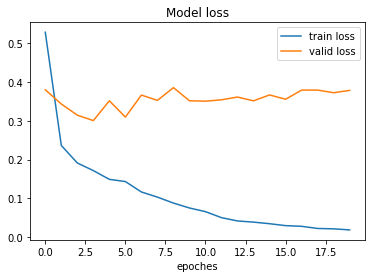

In [51]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_losses)), train_losses, label="train loss")
plt.plot(np.arange(len(val_losses)), val_losses, label="valid loss")

#plt.plot(np.arange(len(val_cores)), val_cores, label="valid cor")
plt.legend() #显示图例
plt.xlabel('epoches')
#plt.ylabel("epoch")
plt.title('Model loss')
plt.show()

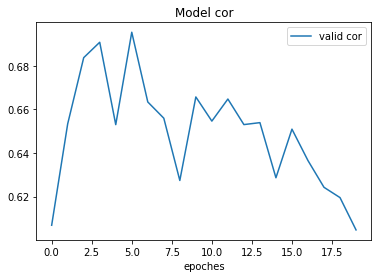

In [52]:
plt.plot(np.arange(len(val_cores)), val_cores, label="valid cor")
plt.legend() #显示图例
plt.xlabel('epoches')
#plt.ylabel("epoch")
plt.title('Model cor')
plt.show()

In [25]:
out = []
# batch_size
for step,(inputs, _) in enumerate(loader_test, 1):
    pred = best_cor_model(inputs.to(device))
    #print(pred.shape)
    out.extend(pred.cpu().detach().numpy())

out = np.array(out)    
print(out.shape)

#——————————————cor————————————————
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)


out = []
# batch_size
for step,(inputs, _) in enumerate(loader_test, 1):
    pred = best_loss_model(inputs.to(device))
    #print(pred.shape)
    out.extend(pred.cpu().detach().numpy())

out = np.array(out)    
print(out.shape)
#——————————————cor————————————————
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)

(384, 1)
0.5674236482492547
(384, 1)
0.5521918996655077


In [20]:
out = []
# batch_size
for step,(inputs, _) in enumerate(loader_test, 1):
    pred = best_loss_model(inputs.to(device))
    #print(pred.shape)
    out.extend(pred.cpu().detach().numpy())

out = np.array(out)    
print(out.shape)

#——————————————cor————————————————
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)

(384, 1)
0.3751743066715552


In [ ]:
testY[:,0]

In [ ]:
out.reshape((-1))

# soda

In [119]:
import pandas as pd 
import datetime
dfhistory = pd.DataFrame(columns = ["epoch","loss","val_loss"]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)
bestloss = float("inf")
epoch = 5
model_epoch = 0
for epoch in range(1,epoch+1):
    #train----------------------------------------------------
  model.train()
  loss_sum = 0.0
  step = 1
  for step,(enc_inputs, dec_outputs) in enumerate(loader_train_sado, 1):
      optimizer.zero_grad()

      # 正向  
      enc_inputs, dec_outputs = enc_inputs.to(device), dec_outputs.to(device)
      y_pred = model(enc_inputs)
      
      loss = criterion(y_pred, dec_outputs) 

      # 反向
      loss.backward()
      optimizer.step()

      # print
      loss_sum += loss.item()
      #if step%40 == 0:
        #print(("[step = %d] loss: %.3f, ") % (step, loss_sum/step))


  #valid
  model.eval()
  val_loss_sum = 0.0
  val_step = 1

  for val_step, (enc_inputs, dec_outputs) in enumerate(loader_valid_soda, 1):
    with torch.no_grad():# 节点不进行求梯度
      enc_inputs, dec_outputs = enc_inputs.to(device), dec_outputs.to(device)
      outputs = model(enc_inputs)
      #val_loss = criterion(outputs.view(-1), dec_outputs.view(-1)) 
      val_loss =criterion(outputs, dec_outputs) 

    val_loss_sum += val_loss.item()


  # log
  info = (epoch, loss_sum/step, val_loss_sum/val_step)
  dfhistory.loc[epoch-1] = info # epoch从1开始 index -1

  # print
  print(("\nEPOCH = %d, loss = %.3f,"+" val_loss = %.3f, ")% info)
  nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  print("\n"+"=========="*8 + "%s"%nowtime)

  if val_loss_sum <= bestloss: #换成小于等于比小于效果更好
    bestloss = (val_loss_sum/val_step)
    best_loss_model = copy.deepcopy(model)#深拷贝
    torch.save(best_loss_model,'bestlossmodel.pkl')
    loss_model_epoch = epoch
    print("+++best loss model updata+++")
        

print('Finished Training...')

out = []
# batch_size
for step,(inputs, _) in enumerate(loader_test, 1):
    pred = model(inputs.to(device))
    out.append(pred.squeeze().cpu().detach().numpy())

out = np.array(out) 
#——————————————cor————————————————
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)

Start Training...
================================================================================2022-05-19 21:39:02

EPOCH = 1, loss = 0.001, val_loss = 0.016, 

================================================================================2022-05-19 21:39:04
+++best loss model updata+++

EPOCH = 2, loss = 0.001, val_loss = 0.016, 

================================================================================2022-05-19 21:39:05

EPOCH = 3, loss = 0.001, val_loss = 0.016, 

================================================================================2022-05-19 21:39:07

EPOCH = 4, loss = 0.002, val_loss = 0.015, 

================================================================================2022-05-19 21:39:08

EPOCH = 5, loss = 0.002, val_loss = 0.016, 

================================================================================2022-05-19 21:39:10
Finished Training...
0.485713817299608


# Evaluation

0.5042937729486838


In [44]:
out = []
# batch_size
model=torch.load('bestmodel_soda.pkl')
for step,(inputs, _) in enumerate(loader_test, 1):
    pred = model(inputs.to(device))
    out.append(pred.squeeze().cpu().detach().numpy())

out = np.array(out)    
print(out.shape)

#——————————————cor————————————————
cor = np.zeros((1))
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)

FileNotFoundError: [Errno 2] No such file or directory: 'bestmodel_soda.pkl'

In [5]:
out = []
# batch_size
model=torch.load('bestmodel.pkl')
for step,(inputs, _) in enumerate(loader_test, 1):
    pred = model(inputs.to(device))
    out.append(pred.squeeze().cpu().detach().numpy())

out = np.array(out)    
print(out.shape)

#——————————————cor————————————————
cor = np.zeros((1))
cor = np.corrcoef(testY[:,0],out.reshape((-1)))[0,1]
print(cor)

(24, 16)
0.8830054444475804


In [17]:
print(model_epoch)

0


In [8]:
testY[:16,0]

array([-0.7828678 , -0.64715624, -0.68216705, -0.86499506, -0.8866562 ,
       -0.8267274 , -0.6234623 , -0.70335156, -0.9443807 , -1.1383914 ,
       -1.158753  , -1.1583354 , -1.180532  , -1.1754164 , -1.0011051 ,
       -0.80188906], dtype=float32)

In [9]:
out[0]

array([ 0.3945299 ,  0.21358556, -0.55354697, -0.40999395, -0.8203296 ,
       -0.46780396, -0.0918841 , -0.05698049, -0.14935665,  0.16960537,
        0.2032471 ,  0.13740295,  0.19149709,  0.08952218,  0.1406549 ,
        0.03880312], dtype=float32)

In [ ]:
pre = model(torch.from_numpy(testX[:10].astype(np.float32)).to(device))
pre.cpu().detach().numpy()
pre.shape

In [6]:
a = np.array([[0,1,2], [3,4,5]])
a.resize(3, 3)
print(a)


[[0 1 2]
 [3 4 5]
 [0 0 0]]


In [41]:
a = np.array([[0,1,2], [3,4,5]])
a.reshape((-1))

array([0, 1, 2, 3, 4, 5])